# Online non-linear regression with corrupted observations

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "E-ANN12": "crimson",
    "IMQF": "dodgerblue",
    "EKF": "lightseagreen",
    "M-EKF": "gold",
}

## Data-generating process

In [3]:
c1, c2, c3, c4 = 1 / 5, -10, 1.0, 1.0
def f(x):
    return c1 * x + c2 * jnp.cos(c3 * jnp.pi * x) + c4 * x ** 3


def sample_observations_grid(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0, p_corrupt=0.1):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    key_cchoice, key_cval = jax.random.split(key_corrupted)
    is_corrupted = jax.random.bernoulli(key_cchoice, p=p_corrupt, shape=(n_obs,))
    ycorr = jax.random.uniform(key_cval, (n_obs,), minval=-50, maxval=50)
    
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jax.random.uniform(key_x, (n_obs,), minval=xmin, maxval=xmax)
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + ycorr * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    # x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y

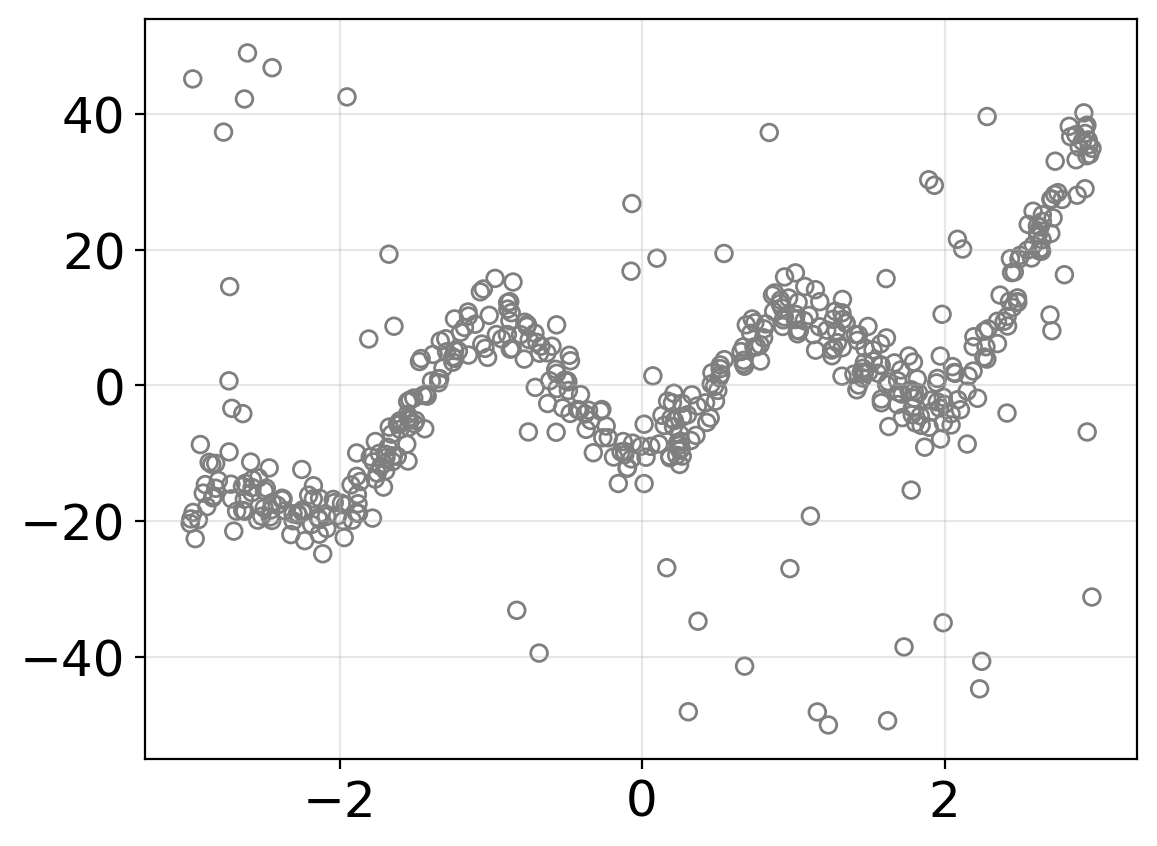

In [4]:
key = jax.random.PRNGKey(314)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 500
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.2, y_noise=sigma_y, p_corrupt=0.15)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
ytest = f(xtest)
plt.scatter(x, y, edgecolors="tab:gray", color="none")
plt.grid(alpha=0.3)

## Filtering

In [5]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [6]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        # x = jnp.sin(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
    

class DGenFn(nn.Module):
    """
    True (non-noisy) data-generating process
    """
    init_var: float = nn.initializers.normal()
        
    @nn.compact
    def __call__(self, x):
        c1 = self.param("c1", self.init_var, (1,))
        c2 = self.param("c2", self.init_var, (1,))
        c3 = self.param("c3", self.init_var, (1,))
        c4 = self.param("c4", self.init_var, (1,))
        
        return c1 * x + c2 * jnp.cos(c3 * jnp.pi * x) + c4 * x ** 3

    
def latent_fn(x): return x

model = MLP()
# model = DGenFn()

### Setup
Parameters shared for all methods

In [7]:
from jax.flatten_util import ravel_pytree

In [8]:
dynamics_covariance = 1e-4
observation_covariance = 1.0

cov_init = 1.0
params_init = model.init(key_train, x[:, None])

n_params, _ = ravel_pytree(params_init)
n_params = len(n_params)
Q = jnp.eye(n_params) * dynamics_covariance


### Extended Kalman Filter

In [9]:
agent_ekf = gf.ExtendedKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=Q,
    observation_covariance=observation_covariance * jnp.eye(1)
    
)

bel_init = agent_ekf.init_bel(params_init, cov=1.0)
callback = partial(callback_fn, applyfn=agent_ekf.vobs_fn)
bel_ekf, yhat_pp_ekf = agent_ekf.scan(bel_init, y, x[:, None], callback_fn=callback)
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

### Robust Extended Kalman Filter

In [10]:
def filter_rkf(noise_scaling):
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        latent_fn, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    return yhat_pp.squeeze(), out

In [11]:
%%time
bo = BayesianOptimization(
    lambda noise_scaling: -jnp.power(filter_rkf(noise_scaling)[0] - y, 2).mean(),
    pbounds={
        "noise_scaling": (1e-6, 10)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   | noise_... |
-------------------------------------
| 3         | -195.7    | 2.65      |
| 6         | -194.3    | 8.274     |
| 23        | -191.6    | 7.795     |
CPU times: user 1min 59s, sys: 2min 15s, total: 4min 14s
Wall time: 17.3 s


In [12]:
noise_scaling = bo.max["params"]["noise_scaling"]
yhat_pp_rekf, (agent_rekf, bel_rekf) = filter_rkf(noise_scaling)
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

### Inverse Multi-quadratic filter

In [13]:
def filter_imqf(soft_threshold):
    agent_imq = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent_imq.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, yhat_pp = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_imq, bel_imq)
    return yhat_pp.squeeze(), out

In [14]:
%%time
bo = BayesianOptimization(
    lambda soft_threshold: -jnp.power(filter_imqf(soft_threshold)[0] - y, 2).mean(),
    pbounds={
        "soft_threshold": (1e-6, 20),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -176.2    | 11.77     |
| 3         | -169.2    | 5.301     |
CPU times: user 3min 17s, sys: 2min 24s, total: 5min 42s
Wall time: 40.4 s


In [15]:
soft_threshold = bo.max["params"]["soft_threshold"]

yhat_pp_imq, (agent_imq, bel_imq) = filter_imqf(soft_threshold)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

## Mahlanobis-based EKF

In [16]:
def filter_mah_ekf(threshold):
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        latent_fn, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

In [17]:
%%time
bo = BayesianOptimization(
    lambda threshold: -jnp.power(filter_mah_ekf(threshold)[0] - y, 2).mean(),
    pbounds={
        "threshold": (1e-6, 20)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   | threshold |
-------------------------------------
| 2         | -238.4    | 11.77     |
| 4         | -213.7    | 15.66     |
| 6         | -209.9    | 16.55     |
| 23        | -207.0    | 14.97     |
CPU times: user 3min 51s, sys: 2min 51s, total: 6min 43s
Wall time: 42 s


In [18]:
threshold = bo.max["params"]["threshold"]
yhat_pp_mekf, (agent_mekf, bel_mekf) = filter_mah_ekf(threshold)
yhat_mekf = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()

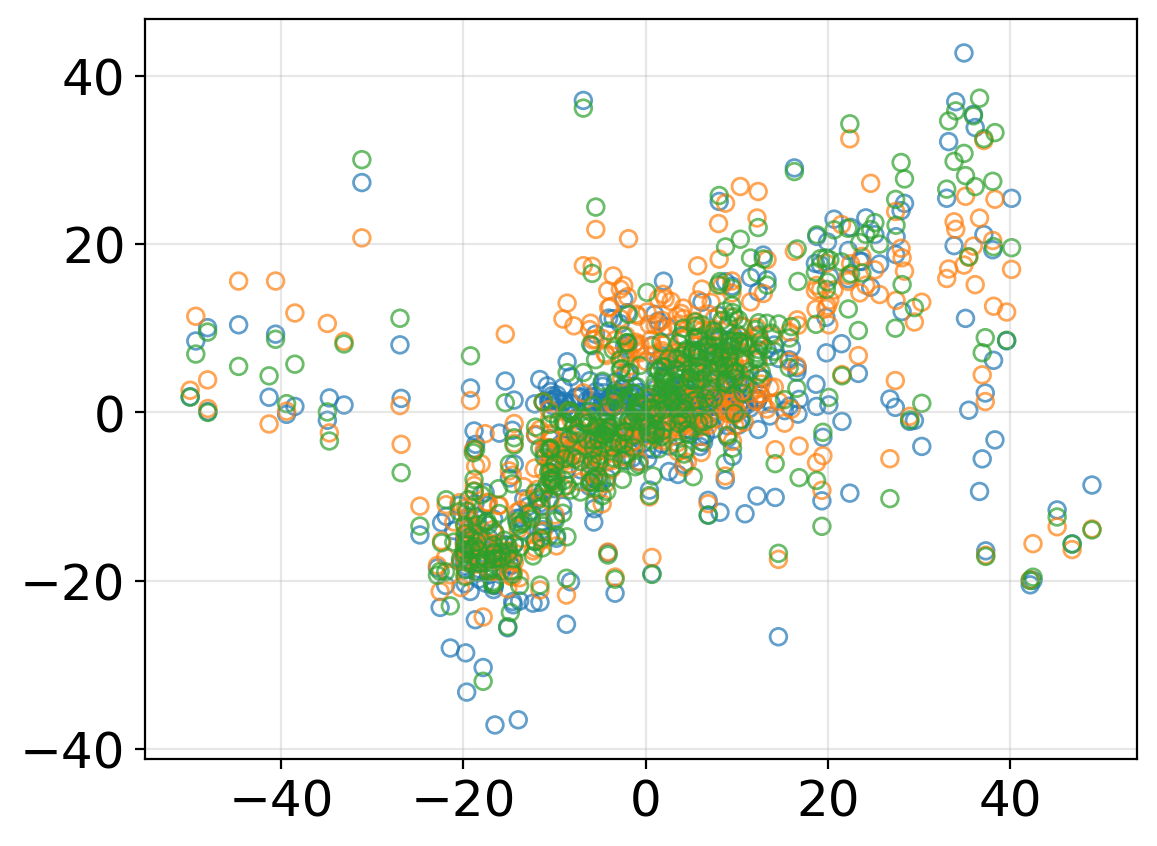

In [19]:
plt.scatter(y, yhat_pp_mekf, edgecolor="tab:blue", c="none", alpha=0.7)
plt.scatter(y, yhat_pp_rekf, edgecolor="tab:orange", c="none", alpha=0.7)
plt.scatter(y, yhat_pp_imq, edgecolor="tab:green", c="none", alpha=0.7)
plt.grid(alpha=0.3)

## Comparison

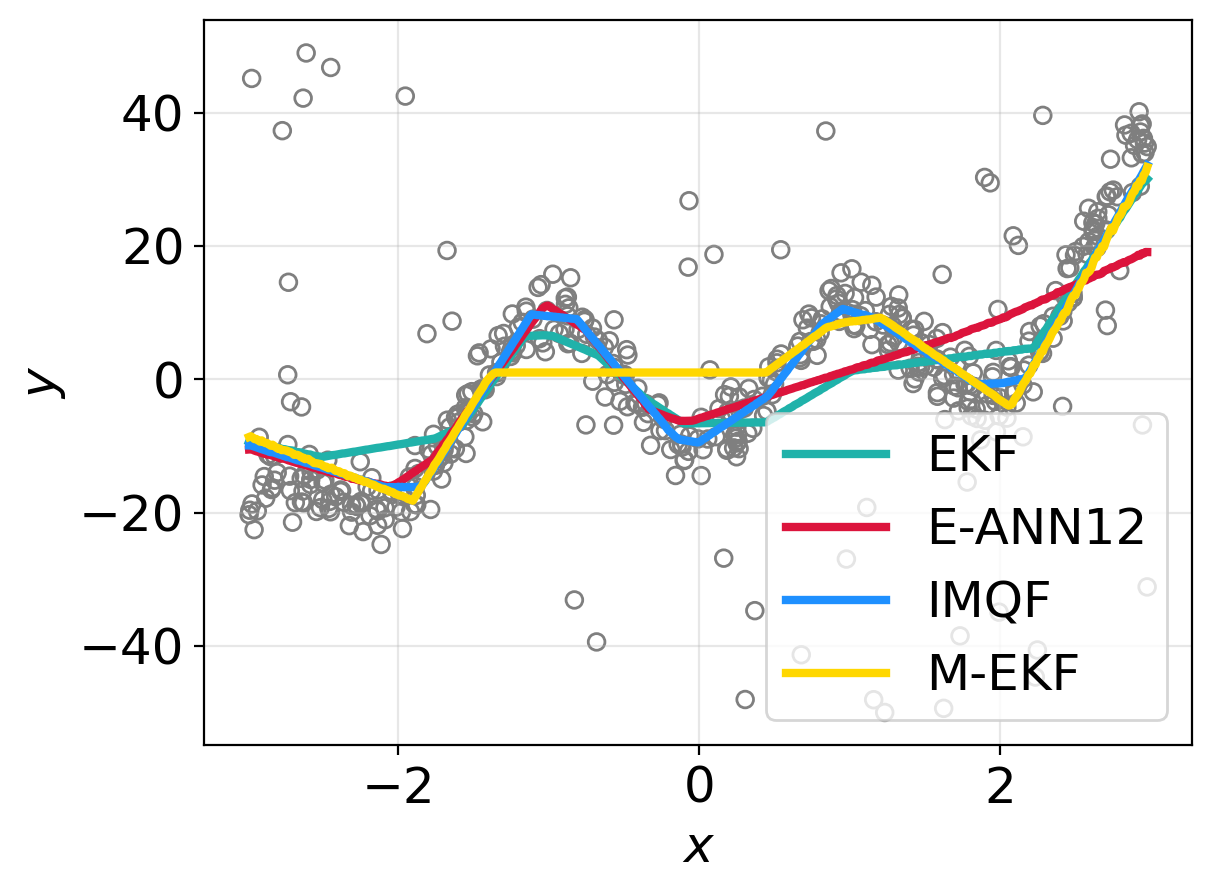

In [20]:
plt.scatter(x, y, edgecolors="tab:gray", c="none")
plt.plot(xtest, yhat_ekf, c="lightseagreen", linewidth=3, label="EKF")
plt.plot(xtest, yhat_rekf, c="crimson", linewidth=3, label="E-ANN12")
plt.plot(xtest, yhat_imq, c="dodgerblue", linewidth=3, label="IMQF")
plt.plot(xtest, yhat_mekf, c="gold", linewidth=3, label="M-EKF")
plt.grid(alpha=0.3)
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig("./figures/online-mlp-sample.pdf")

## Multiple runs

In [21]:
ytest = f(xtest)
n_obs = 500

@jax.jit
@jax.vmap
def sample_and_eval(key):
    key_train, key_sample_obs, key_eval = jax.random.split(key, 3)
    x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
    params_init = model.init(key_train, x[:, None])
    
    bel_init = agent_ekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_ekf.vobs_fn)
    bel_ekf, ekf_hist = agent_ekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_rekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, rekf_hist = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

    bel_init = agent_imq.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, imq_hist = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()
    
    
    bel_init = agent_mekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    bel_mekf, mekf_hist = agent_mekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_mekf = agent_mekf.vobs_fn(bel_mekf.mean, xtest[:, None]).ravel()


    errs = {
        "E-ANN12": yhat_rekf,
        "IMQF": yhat_imq,
        "EKF": yhat_ekf,
        "M-EKF": yhat_mekf,
    }
    
    # One-step-ahead errors
    errs_osa = {
        "E-ANN12": rekf_hist,
        "IMQF": imq_hist,
        "EKF": ekf_hist,
        "M-EKF": mekf_hist,
    }
    errs_osa = jax.tree_map(lambda yhat: yhat.squeeze() - y, errs_osa)
        
    
    errs = jax.tree_map(lambda yhat: jnp.sqrt(jnp.power(yhat - ytest, 2).mean()), errs)
    
    return errs, errs_osa

In [22]:
%%time
n_sims = 100
keys = jax.random.split(key_eval, n_sims)
results, errs_osa = sample_and_eval(keys)
results = jax.tree_map(np.array, results)
errs_osa = jax.tree_map(lambda x: np.array(x.squeeze()), errs_osa)
results_df = pd.DataFrame(results)

CPU times: user 41.3 s, sys: 4.19 s, total: 45.4 s
Wall time: 1min 13s


In [23]:
np.sqrt(jnp.power(errs_osa["E-ANN12"], 2).sum(axis=-1).mean(axis=0))

1858.6075

In [24]:
np.sqrt(jnp.power(errs_osa["M-EKF"], 2).sum(axis=-1).mean(axis=0))

385.53552

In [25]:
np.sqrt(jnp.power(errs_osa["IMQF"], 2).sum(axis=-1).mean(axis=0))

282.4942

In [26]:
def running_mean(errs):
    errs = errs[:, 0:]
    _, nsteps = errs.shape
    return np.sqrt(np.power(errs, 2).cumsum(axis=1) / np.arange(1, nsteps + 1)[None])
    return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))

errs_rmean = jax.tree_map(running_mean, errs_osa)

/tmp/ipykernel_829438/2224783514.py:4: RuntimeWarning: overflow encountered in power
  return np.sqrt(np.power(errs, 2).cumsum(axis=1) / np.arange(1, nsteps + 1)[None])


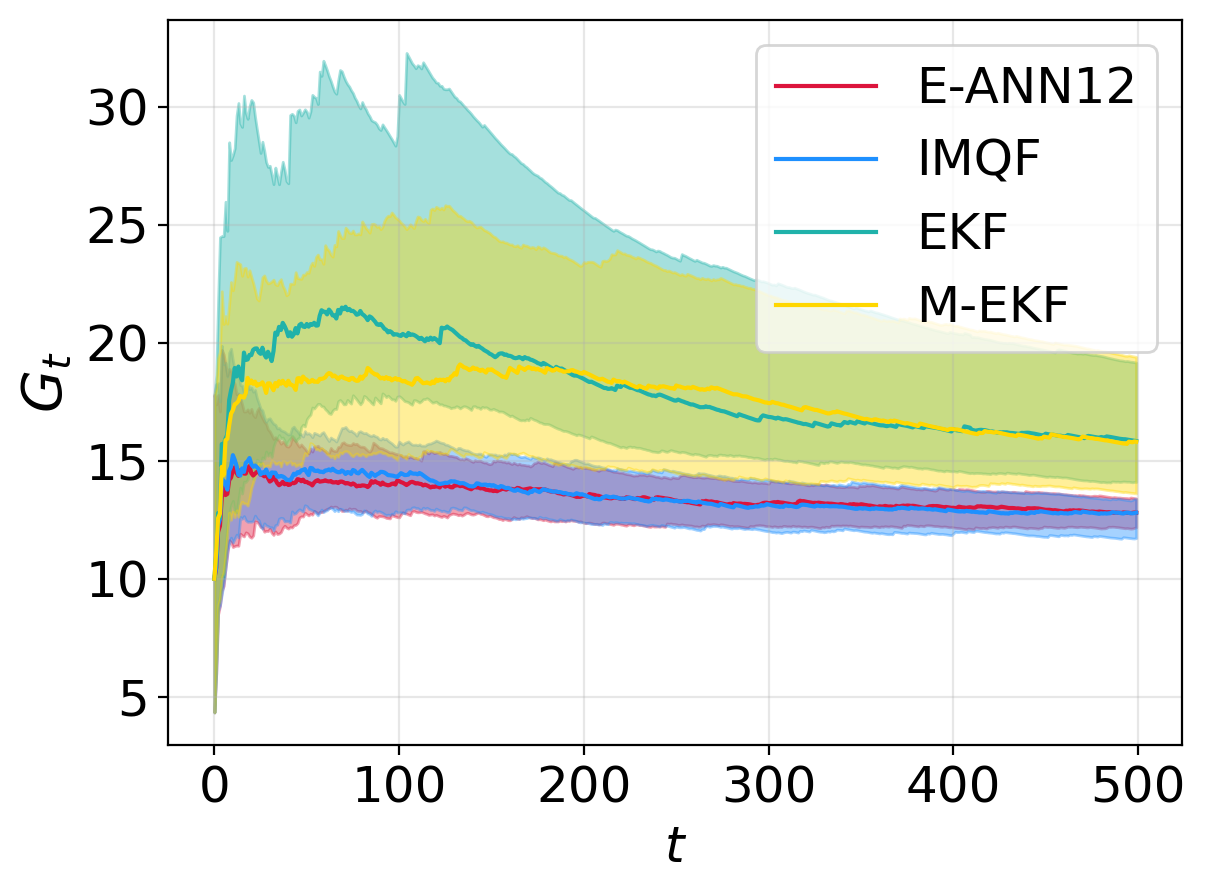

In [27]:
for method in cmap:
    plt.plot(np.nanquantile(errs_rmean[method], 0.5, axis=0), c=cmap[method], label=method)
    vmin, vmax = np.nanquantile(errs_rmean[method], [0.2, 0.8], axis=0)
    plt.fill_between(np.arange(len(vmin)), vmin, vmax, color=cmap[method], alpha=0.4)

# plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$G_t$", fontsize=20)
plt.tight_layout()
plt.savefig("./figures/online-mlp-osa-benchmark.pdf")

In [28]:
results_osa_df = jax.tree_map(lambda errs: jnp.sqrt(jnp.power(errs, 2)[:, 0:].sum(axis=1)), errs_osa)
results_osa_df = pd.DataFrame(results_osa_df)
results_osa_df.describe()

,E-ANN12,EKF,IMQF,M-EKF
count,100.000000,98.000000,100.000000,100.000000
mean,537.690369,442.842346,281.658783,375.240662
std,1788.094971,350.732971,21.818995,88.944603
min,234.594055,271.744965,219.099091,254.641754
25%,275.080399,322.220490,265.634048,310.799423
50%,286.221970,354.096436,286.268784,353.460144
75%,297.719261,396.275726,295.980972,407.535164
max,15045.288086,3337.498047,333.299744,673.404846


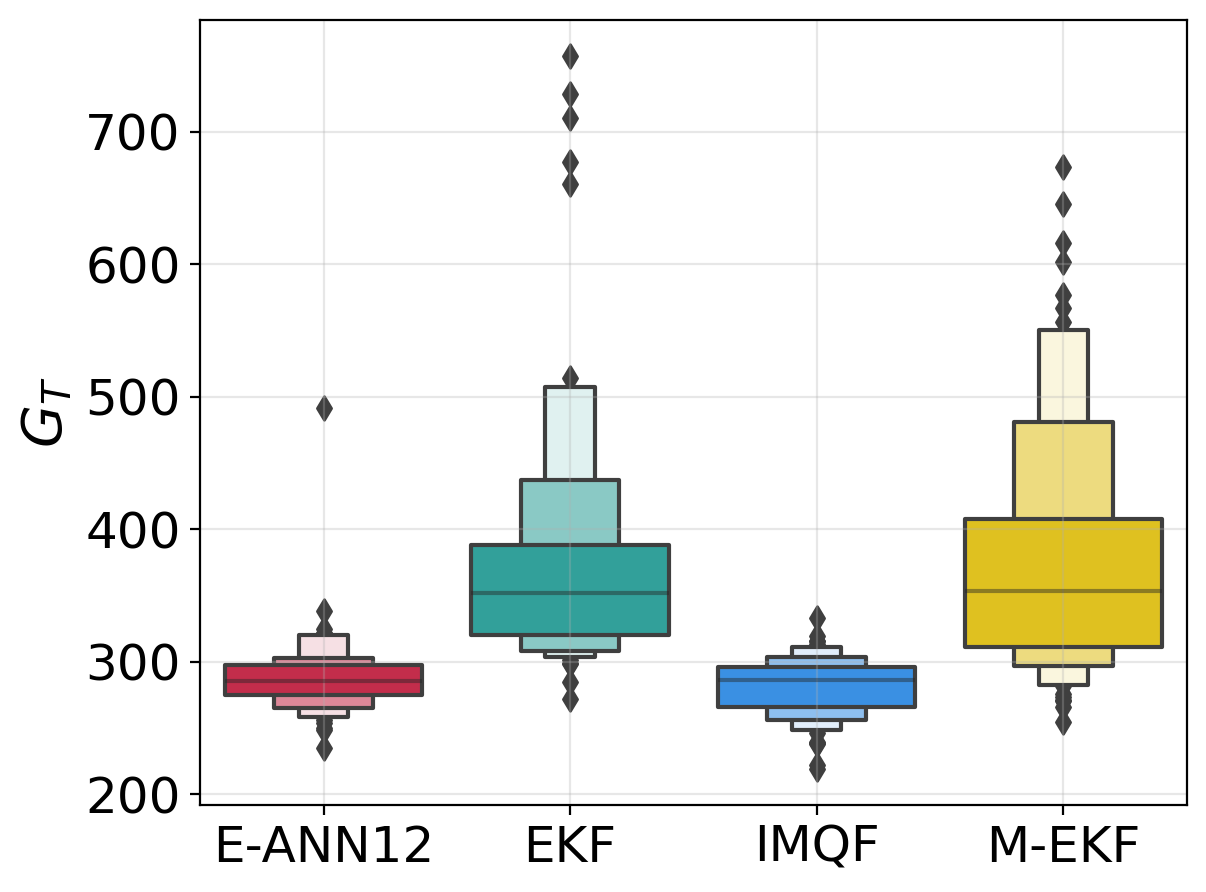

In [29]:
sns.boxenplot(
    results_osa_df.melt().query("value < 800"),
    x="variable", y="value",
    palette=cmap
)
plt.grid(alpha=0.3)
# plt.yscale("log")
plt.xlabel("")
plt.ylabel("$G_T$", fontsize=20)
plt.tight_layout()
plt.savefig("./figures/online-mlp-benchmark.pdf")